In [1]:
import numpy as np
from numpy.linalg import det ,inv
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

import sys
# setting path
sys.path.append('/Users/voicutu/Documents/GitHub/vdw_evolve/sandbox/vdw')


from genetic import Gen1

import random
random.seed(99)

In [2]:

eps = 0.0001

bond=10

def tAtB(params):
    tA = np.array([[params[0],params[1]],
                   [params[2],params[3]]])
    
    tB = np.dot(np.dot(tA,a), inv(b)) # tAa=tBb
    
    return tA, tB

In [3]:
def subject_test(params):
    tA, tB= tAtB(params)
    if det(tA)==0:
        return False
    if det(tB)==0:
        return False
    return True

In [4]:
class MinimalSupercel_generation(Gen1):
    
        def first_generation(self):
            """
            This function will generate a random generation of possible solutions based on the model hyper parameters
            :return::[[int, int ,...],[int,..]]
            """
            generation_0 = []

            number_of_cells = self._nr_cells()

            for cell_nr in range(number_of_cells):
                cell_constrains = []

                for f in range(self.input_size):
                    feature = self.input_size - f - 1
                    cell_coordinate = int(cell_nr / (self.model_par["cell_split_number"] ** feature))
                    cell_nr = cell_nr - cell_coordinate * int((self.model_par["cell_split_number"] ** feature))

                    interval = (-self.input_ranges[feature][0] + self.input_ranges[feature][1]) / self.model_par[
                        'cell_split_number']
                    c_0 = self.input_ranges[feature][0] + interval * cell_coordinate
                    c_1 = self.input_ranges[feature][0] + interval * (cell_coordinate + 1)
                    constrain = [c_0, c_1]
                    cell_constrains.append(constrain)


                # 0_in_cell_enhancement
                subjects_in_cell = self.model_par["subjects_in_cell"]
                for feature_bound in cell_constrains:
                    if feature_bound[0]<=0<=feature_bound[0]:
                        subjects_in_cell =subjects_in_cell*self.model_par["0_in_cell_enhancement"]


                for subject_number in range(subjects_in_cell):
                    subject = []
                    for feature_bound in cell_constrains:
                        new_subject = random.randint(int(feature_bound[0]), int(feature_bound[1]))
                        subject.append(new_subject)
                        
                    while not subject_test(subject):
                        subject = []
                        for feature_bound in cell_constrains:
                            new_subject = random.randint(int(feature_bound[0]), int(feature_bound[1]))
                            subject.append(new_subject)
                        
                    generation_0.append(subject)

            return generation_0

        def mating(self, parent_1, parent_2):
            """

            :param parent_1:: [int, int, ..]
            :param parent_2:: [int, int, ..]
            :return:: [int, int, ..]
            """
            children = []
            for char_nr in range(len(parent_1)):
                new_char = round((parent_1[char_nr] + parent_2[char_nr]) / 2)
                children.append(new_char)
            
            while not subject_test(children):
                new_children = []
                for i in range(len(children)):
                    new_children.append(self.mutation(children[i], bounds=self.input_ranges[i]))
                    
                children =new_children
            return children

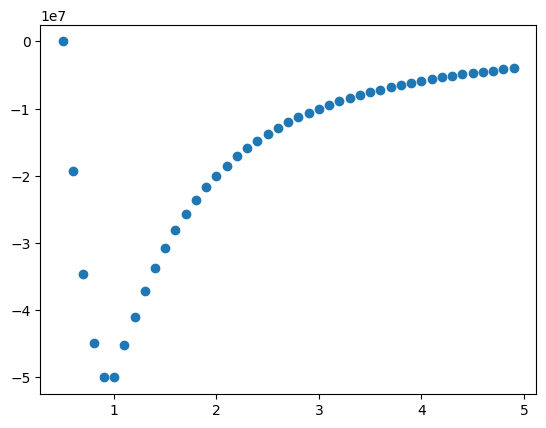

In [5]:
def at_sin(x, up =99999999):
    
    tr_x= (x + 0.5)
    
    if x<1:
        res = up*(1/(1+np.sqrt((x**2))) )* np.sin(tr_x*np.pi) +1/(x+0.00000000000001)
    else:
        res = (x-1)**2 -up*(1/(1+x**2))+1/(x+0.00000000000001)
    return res

X = [i*0.1 for i in range(0,50,1)]
Y= [at_sin(x) for x in X]

plt.scatter(X[5:],Y[5:])

In [6]:
a1 = [1,0]; a2=[0,1];
A  = np.transpose([a1,a2]);

theta =  np.pi/4;
R = [ [ np.cos(theta), -np.sin(theta)], [ np.sin(theta),  np.cos(theta)] ];

b1 = np.sqrt(2)*np.dot(R,a1);  b2 = np.sqrt(2)*np.dot(R,a2); #a2
#b1 = [np.sqrt(3),0]; b2=[0,np.sqrt(3)];

B  = np.transpose([b1,b2]);

a = A#np.array([[0,1],[1,0]])
b = B#np.array([[0,5],[5,0]])

In [7]:
          
def fit_fucntion(params , k_p=999):
          
        tA, tB= tAtB(params)
        tAa= np.dot(tA,a)
        tBb= np.dot(tB,b)
        
        # main condition
        zero_mat= tAa - tBb
        s=0
        for row in zero_mat:
            for e in row:
                s+=e*e
        
        # mimimum TA
        detTAa= det(tAa)*det(tAa) # minimum but biger than 0
        detTBb= det(tBb)*det(tBb)
        
        # TB integer 
        cons =9999999
        tB_con = 0  
        for row in tB:
            for e in row:
                tB_con += ((round(e)-e))*((round(e)-e)) # e*e
        tB_con = tB_con*cons
        
        tA_lenghth =((tA[0][0]**2+tA[0][1]**2)+(tA[1][0]**2+tA[1][1]**2) )*100
        
        
        f =  at_sin(detTAa)+ tB_con**2 +tA_lenghth
        #((1-detTAa)**2)*k_p + tB_con**2
        
        
        return f 

In [8]:
# Experiment settings

#Hyperparameters of the model
model_par = {
    
    'cell_split_number': 2, 
    'subjects_in_cell': 2,
    '0_in_cell_enhancement':2,

    'nr_clones': 10,
    'mutation_gaussian_sd': 4,

    'pins': 7,
    'gene_quality': 1,
    
}




input_size = 4 # P=[tA00,tA01,tA10,tA11]

bounds =[[-bond,bond]for _ in range(input_size)] # searching intervals for the solution

# Experiment
experiment = MinimalSupercel_generation(fit_fucntion ,input_size, bounds, model_par)

In [9]:
## Automate evolution

nr_epochs = 50
last_generation = experiment.evolve(nr_epochs)
fit = [fit_fucntion(x) for x in last_generation] 
print("fit:",fit)


Epochs 0/50
perf [-56021.99083752255, -246262.12048306785, 71275.97376424226, -119976.4134810777, 17039.08762127779, -112776.41348107756, 15239.087621277791, -166176.00641247578, -6259985.000402716, -251662.1204830682, -28026.708685294136, -163576.00641247578, -35826.70868529419, -79699.14829796777, -633326.3089137549, 371679.99197470816, -121576.4134810777, 72075.97376424226, -167576.00641247578, -40965198.558750026, -818077.5444746395, -630726.3089137536, 384479.99197470816, 60075.97376424208, -8202.010000000018, -78299.14829796762, -45621.99083752246, -49790822.99159078, -2565761.9381406493, -11329560.163640555, -66699.14829796762, 13839.087621277791, 7239.087621277791, -172576.00641247578, 7239.087621277791, 5875543.632352954, -463206.172087438, -24999995285526.777, -819077.5444746366, -92238007.91593818, -18980219.730064314, 16839.08762127774, -21226.708685294136, -10802.00999999999, -338523.5944685786, -2802.0099999999893, -818077.5444746395, -47221.99083752246, -24826.7086852941

perf [5881743.632352941, 16239.087621277791, -40821.99083752246, 5881743.632352941, -24999994612820.19, 74475.97376424226, 13039.087621277791, 5881743.632352941, 5881743.632352941, -20626.708685294136, 5878743.632352949, 387079.99197470816, -110176.41348107756, 5881743.632352941, 387879.99197470816, -70299.14829796762, 5881743.632352941, 69675.97376424226, 5881743.632352941, 72075.97376424226, -24999995003060.914, 62475.973764242255, 5878743.6323529435, 387079.99197470816, 386079.99197470816, 386079.99197470816, 386079.99197470816, 386079.99197470816]
Epochs 11/50
perf [387079.99197470816, -18426.708685294136, -164576.00641247578, -14802.00999999999, 380679.9919747085, -18426.708685294136, 5880143.632352941, 386079.99197470816, 5880943.632352941, -69299.14829796762, -47221.99083752255, 5881143.632352936, 5881743.632352941, 5878743.6323529435, 387079.9919747078, 18439.08762127774, -2802.0100000000184, -337723.5944685786, 5881743.632352941, 5881743.632352941, 5881743.632352941, 5881743.6

perf [386479.99197470816, 72075.97376424226, 72075.97376424226, 5881943.632352941, 384479.9919747078, 72075.97376424226, -338523.5944685786, 5876943.632352941, 5876943.632352941, 72075.97376424226, 386479.99197470816, 386479.99197470816, 386479.99197470816, 5876943.632352941, 381679.9919747085, 387679.99197470816, 386479.99197470816, 386479.99197470816, 386479.99197470816, 15239.087621277791, 387079.99197470816, 382879.9919747085, 5880943.632352941, 5880943.632352941, 5880943.632352941, 5880943.632352941, 5880943.632352941, 5880943.632352941]
Epochs 26/50
perf [5876943.632352941, 386479.99197470816, 386479.99197470816, 5878743.632352949, 382879.9919747078, 72075.97376424226, 72075.97376424226, 5880943.632352941, 5880943.632352941, -6802.009999999989, -5802.009999999989, -4484002.666366645, -70099.14829796762, 5880943.632352941, -8510613.239866797, 14839.087621277791, -18426.708685294136, -23826.708685294136, 5876943.632352941, 386479.99197470816, 386479.99197470816, 386479.99197470816,

perf [5876943.632352941, 386479.99197470816, 5881743.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5881743.632352941, 386479.99197470816, 386479.99197470816, 5881143.632352941, 386479.99197470816, 386479.99197470816, 5876943.632352941, 5876943.632352941, 5881743.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941]
Epochs 41/50
perf [5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5878743.6323529435, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 5876943.632352941, 

In [10]:
best =last_generation [fit.index(min(fit))]
print(best)

[-1, -1, 0, -2]


In [11]:
P = best #[1, 1, 0, 1]#[2, 0, 0, -1]#[0, -1, -1, 0]#[-1, 1, 0, 1]
tA,tB = tAtB(P)
zero_mat= np.dot(tA,a) - np.dot(tB,b)
print("\n _____\n tA:\n",tA)
print("det:",det(tA))
print("\n _____\n tB:\n",tB)
print("det:",det(tB))
print("\n zero_mat:\n",zero_mat)


 _____
 tA:
 [[-1 -1]
 [ 0 -2]]
det: 2.0

 _____
 tB:
 [[-1.11022302e-16 -1.00000000e+00]
 [ 1.00000000e+00 -1.00000000e+00]]
det: 0.9999999999999998

 zero_mat:
 [[ 0.00000000e+00 -1.11022302e-16]
 [ 0.00000000e+00  0.00000000e+00]]


In [12]:
#StB=tB_round
def get_strain(tB):
    tBr= tB.copy()
    for i in range(len(tB)):
        for j in range(len(tB[0])):
            tBr[i][j]=round(tB[i][j])
    S =np.dot(tBr,inv(tB))
    return(S)

S= get_strain(tB)
print("Strain:",get_strain(tB))

Strain: [[ 1.00000000e+00  1.11022302e-16]
 [-2.22044605e-16  1.00000000e+00]]
